<a href="https://colab.research.google.com/github/varshi/Data-Projects/blob/main/Sentiment%20Analysis%20using%20NLP/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Install & Import

!pip install -q scikit-learn pandas numpy matplotlib seaborn nltk transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Load the manually uploaded dataset
df = pd.read_csv("/content/sample_app_reviews (2).csv")
df.head()

,Translated_Review,Sentiment,label
0,"Great app, very helpful!",Positive,1
1,"Terrible experience, it kept crashing.",Negative,0
2,Love the new update!,Positive,1
3,Worst app ever,Negative,0
4,Does what it promises. Satisfied.,Positive,1


from matplotlib import pyplot as plt
_df_0['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Translated_Review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Sentiment'].value_counts()
    for x_label, grp in _df_4.groupby('Translated_Review')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Translated_Review')
_ = plt.ylabel('Sentiment')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['Translated_Review'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='label', y='Translated_Review', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['Sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='label', y='Sentiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_9.groupby('Translated_Review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_10.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='index', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Translated_Review')):
  _plot_series(series, series_name, i)
  fig.legend(title='Translated_Review', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Sentiment')):
  _plot_series(series, series_name, i)
  fig.legend(title='Sentiment', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Translated_Review')):
  _plot_series(series, series_name, i)
  fig.legend(title='Translated_Review', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Sentiment')):
  _plot_series(series, series_name, i)
  fig.legend(title='Sentiment', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Sentiment'].value_counts()
    for x_label, grp in _df_18.groupby('Translated_Review')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Translated_Review')
_ = plt.ylabel('Sentiment')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Translated_Review'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='Translated_Review', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='index', y='Sentiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['Translated_Review'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='label', y='Translated_Review', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['Sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='label', y='Sentiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

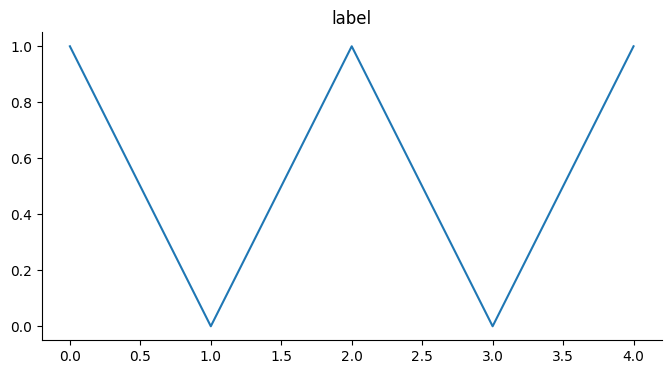

In [12]:
# @title label

from matplotlib import pyplot as plt
df['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
# Clean Reviews
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\\s]', '', text.lower())
    words = text.split()
    return ' '.join([w for w in words if w not in stop_words])

df['clean_review'] = df['Translated_Review'].apply(clean_text)


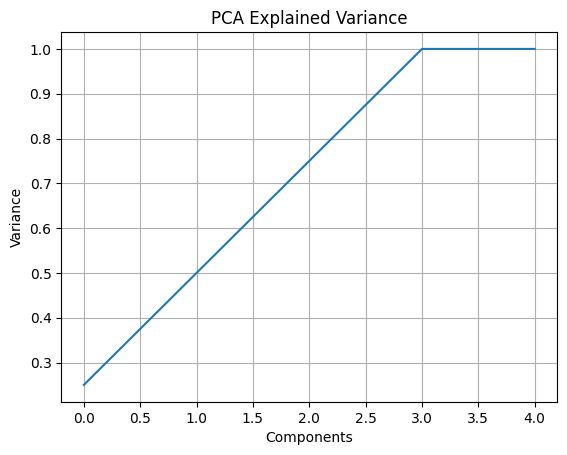

In [7]:
# TF-IDF and PCA
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df['clean_review'])
y = df['label']

pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X.toarray())

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA Explained Variance")
plt.xlabel("Components")
plt.ylabel("Variance")
plt.grid(True)
plt.show()


In [8]:
# Train Models
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft')
ensemble.fit(X_train, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

✅ Accuracy: 0.00%
❗ Type I Error: 100.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

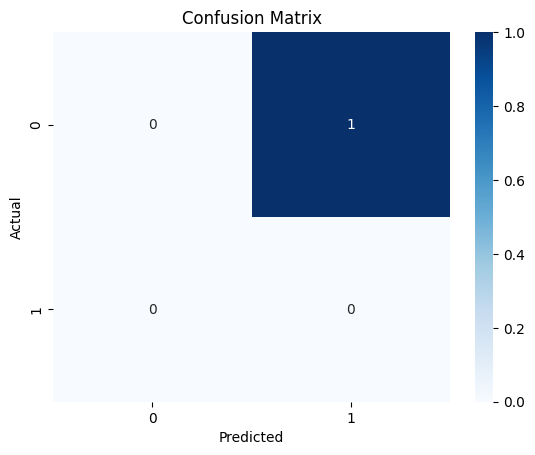

In [9]:
# Evaluate
y_pred = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
type1_error = cm[0][1] / (cm[0][0] + cm[0][1]) if (cm[0][0] + cm[0][1]) else 0

print(f"✅ Accuracy: {acc*100:.2f}%")
print(f"❗ Type I Error: {type1_error*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:
#RoBERTa Setup Cell:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

def roberta_predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    scores = softmax(outputs.logits.detach().numpy()[0])
    return np.argmax(scores)  # 0 = neg, 1 = neutral, 2 = pos


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🤖 RoBERTa Accuracy: 100.00%
❗ Type I Error: 0.00%


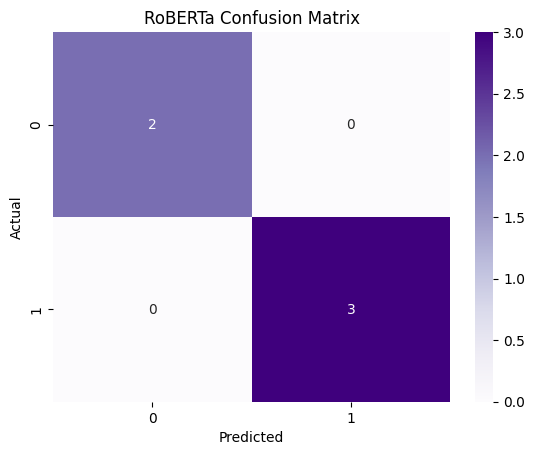

In [11]:
#RoBERTa Evaluation Cell
sample_reviews = df['Translated_Review'].iloc[:100].tolist()
sample_labels = df['label'].iloc[:100].tolist()
roberta_preds = [1 if roberta_predict(r) == 2 else 0 for r in sample_reviews]

from sklearn.metrics import accuracy_score, confusion_matrix
roberta_acc = accuracy_score(sample_labels, roberta_preds)
roberta_cm = confusion_matrix(sample_labels, roberta_preds)
roberta_type1 = roberta_cm[0][1] / (roberta_cm[0][0] + roberta_cm[0][1]) if (roberta_cm[0][0] + roberta_cm[0][1]) else 0

print(f"🤖 RoBERTa Accuracy: {roberta_acc*100:.2f}%")
print(f"❗ Type I Error: {roberta_type1*100:.2f}%")

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(roberta_cm, annot=True, fmt='d', cmap='Purples')
plt.title("RoBERTa Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
